<a href="https://colab.research.google.com/github/pingwx/ya.prac/blob/main/08_ML_in_business/08_RU_ML_in_business_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Выбор локации для скважины

В нашем распоряжении данные о пробах нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Заказчик - добывающая компания «ГлавРосГосНефть» просит нас определить, где бурить новые скважины.

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Заказчик просит выбрать наилучший регион, проанализировать возможную прибыль и риски.


**Описание данных:**

Данные геологоразведки трёх регионов находятся в файлах:
- `/datasets/geo_data_0.csv`.
- `/datasets/geo_data_1.csv`. 
- `/datasets/geo_data_2.csv`. 
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек;
- `product` — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
state = np.random.RandomState(12345)

Последовательно загрузим данные из трех датасетов, посмотрим на распределение признаков и целевого признака `product`

### Регион 0:

In [3]:
geo_data_0 = pd.read_csv('/content/geo_data_0.csv')
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


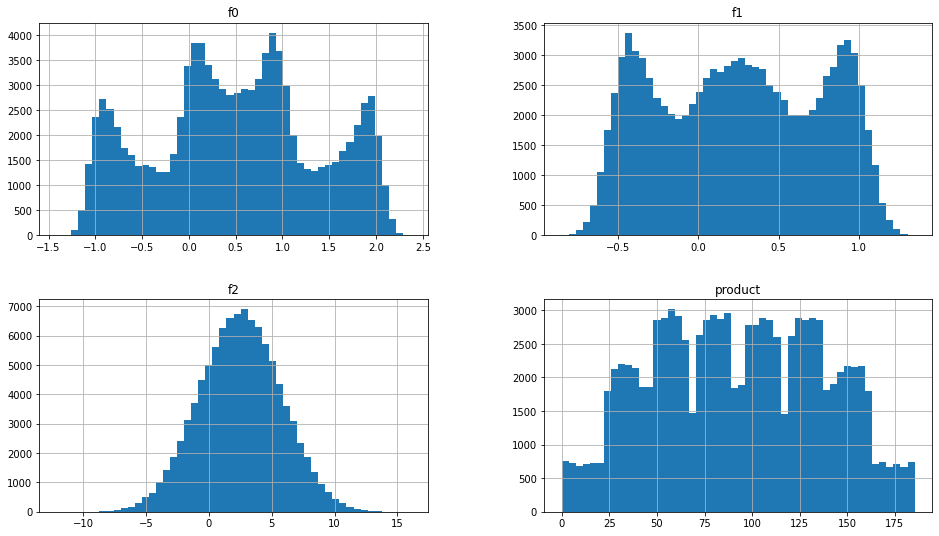

In [4]:
geo_data_0.hist(figsize=(16,9), bins=50);

### Регион 1:

In [5]:
geo_data_1 = pd.read_csv('/content/geo_data_1.csv')
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


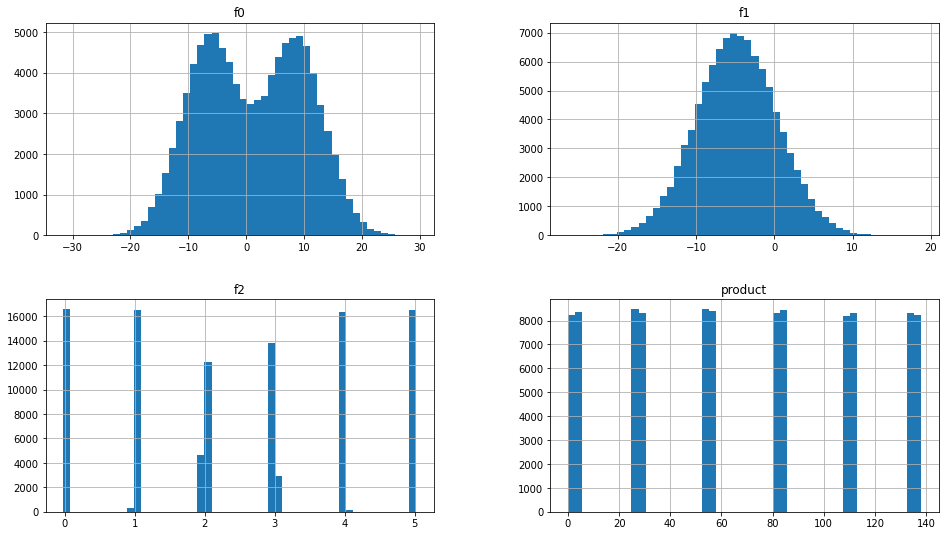

In [6]:
geo_data_1.hist(figsize=(16,9), bins=50);

### Регион 2:

In [7]:
geo_data_2 = pd.read_csv('/content/geo_data_2.csv')
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


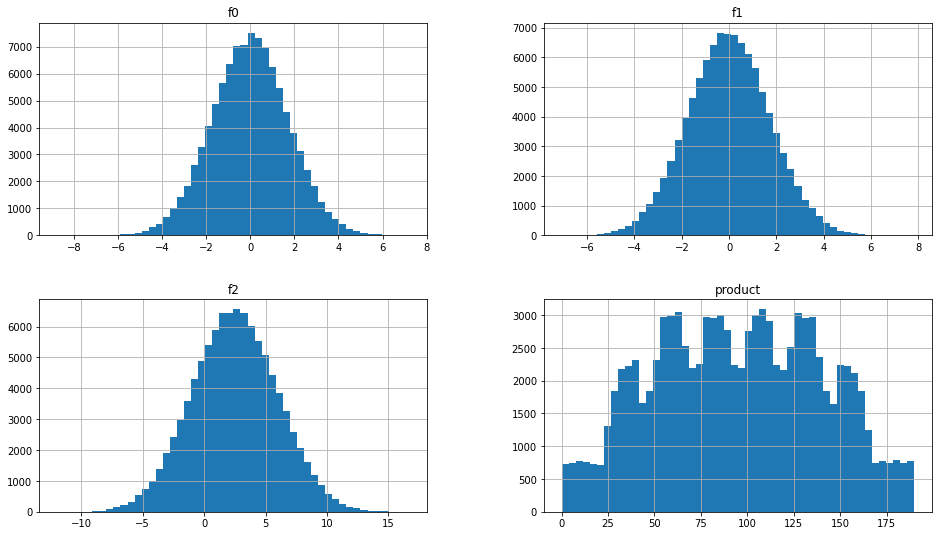

In [8]:
geo_data_2.hist(figsize=(16,9), bins=50);

### Вывод:

Датасеты загружены. Мы убедились, что в датасетах нет пропусков, и их длинна соответствует заявленной в условии. Обратим внимание, что признаки в трех регионах распределены очень по-разному. Распределения в регионе 2 наиболее похожи на нормальные. В регионе 0 признаки `f1` и `f0` имеют пики по краям, а признак `f2` распределен нормально. В регионе 1 признак `f2` имеет фактически дискретный вид. Целевой признак `product` во всех регионах имеет весьма неравномерое распределение, а в регионе 1 имеет практически дискретный вид.

## Обучение и проверка модели

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
state = np.random.RandomState(12345)

Для каждого региона обучим свою модель. Во избежании дублирования кода определим функцию, в которой:

- сформируем `X` - набор признаков `f0`, `f1`, `f2`
- сформируем `y` - целевой признак `product`
- разделим выборку на обучающую и валидационную в соотношении 3:1
- стандартизируем признаки `f0`, `f1`, `f2`
- обучим модель линейной регрессии на обучающей выборке
- сделаем предсказания на валидационной выборке
- расчитаем RMSE
- сохраним датасет `result` с двумя колонками `predict` и `target` в которых будут хранится предсказанные и целевые значения соответственно
- вернем значение RMSE и датасет `result`

In [10]:
def train_model(data):
    X = data[['f0', 'f1', 'f2']]
    y = data['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=12345)
    stdsc = StandardScaler()
    X_train = stdsc.fit_transform(X_train)
    X_valid = stdsc.transform(X_valid)
    model = LinearRegression()
    model.fit(X_train, y_train)
    predict = model.predict(X_valid)
    rmse = mean_squared_error(predict, y_valid) ** 0.5
    result = pd.DataFrame()
    result['predict'] = predict
    result['target'] = y_valid.to_numpy()
    return rmse, result

### Регион 0:

In [11]:
rmse_0, result_0 = train_model(geo_data_0)
print('Средний запас предсказанного сырья в регионе 0:', '%.2f'%result_0['predict'].mean())
print('RMSE модели:', '%.2f'%rmse_0)

Средний запас предсказанного сырья в регионе 0: 92.59
RMSE модели: 37.58


### Регион 1:

In [12]:
rmse_1, result_1 = train_model(geo_data_1)
print('Средний запас предсказанного сырья в регионе 1:', '%.2f'%result_1['predict'].mean())
print('RMSE модели:', '%.2f'%rmse_1)

Средний запас предсказанного сырья в регионе 1: 68.73
RMSE модели: 0.89


### Регион 2:

In [13]:
rmse_2, result_2 = train_model(geo_data_2)
print('Средний запас предсказанного сырья в регионе 2:', '%.2f'%result_2['predict'].mean())
print('RMSE модели:', '%.2f'%rmse_2)

Средний запас предсказанного сырья в регионе 2: 94.97
RMSE модели: 40.03


### Вывод:

Мы наблюдаем, что значения среднего запаса и RMSE для регионов 0 и 2 похожи друг на друга, а в регионе 2 среднее значение существенно меньше. Однако, регион 1 имеет подозрительно низкое значение RMSE. Попробуем разобраться, как так вышло:

In [14]:
geo_data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Мы видим, что в регионе 1 столбцы `f2`и `product` линейно зависимы, этим объясняется столь низкая ошибка предсказаний. В регионах 0 и 2 нет линейной зависимости между признаками и целевым признаком. Построим трехмерные scatter-plot'ы с распределениями признаков `f0`, `f1`, `f2`. Цвет точек будем менять в зависимости от соответсвтующих значений `product`.

In [15]:
def show_f0123_scatter(data, alpha=0.12):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('f0', fontsize=20)
    ax.set_ylabel('f1', fontsize=20)
    ax.set_zlabel('f2', fontsize=20)
    scat_plot = ax.scatter(data['f0'], data['f1'], data['f2'], c=data['product'], alpha=alpha)
    cb = plt.colorbar(scat_plot)
    num_ticks = 20
    ticks = [j*data['product'].max()/num_ticks for j in range(num_ticks)]
    cb.set_ticks(ticks)
    cb.set_label('product', size=20)
    plt.show()

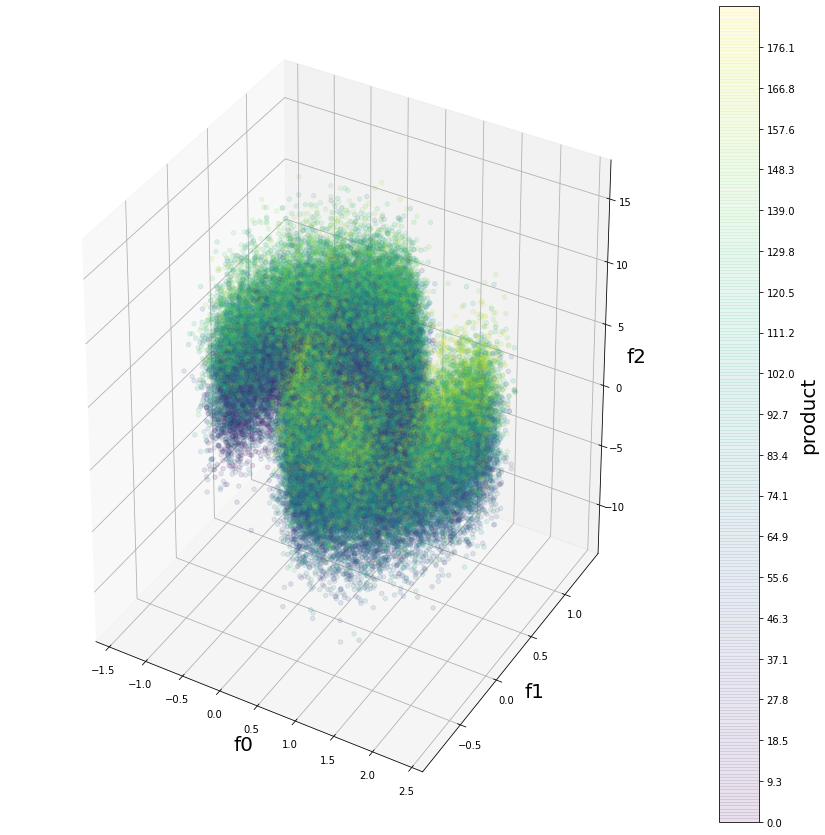

In [16]:
show_f0123_scatter(geo_data_0) #Регион 0

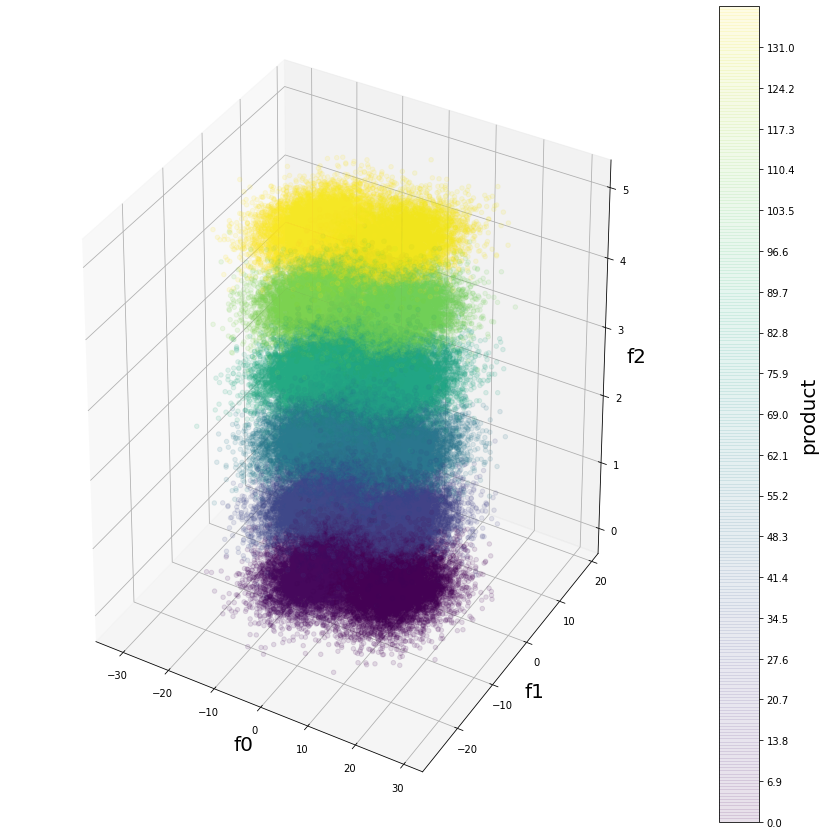

In [17]:
show_f0123_scatter(geo_data_1) #регион 1

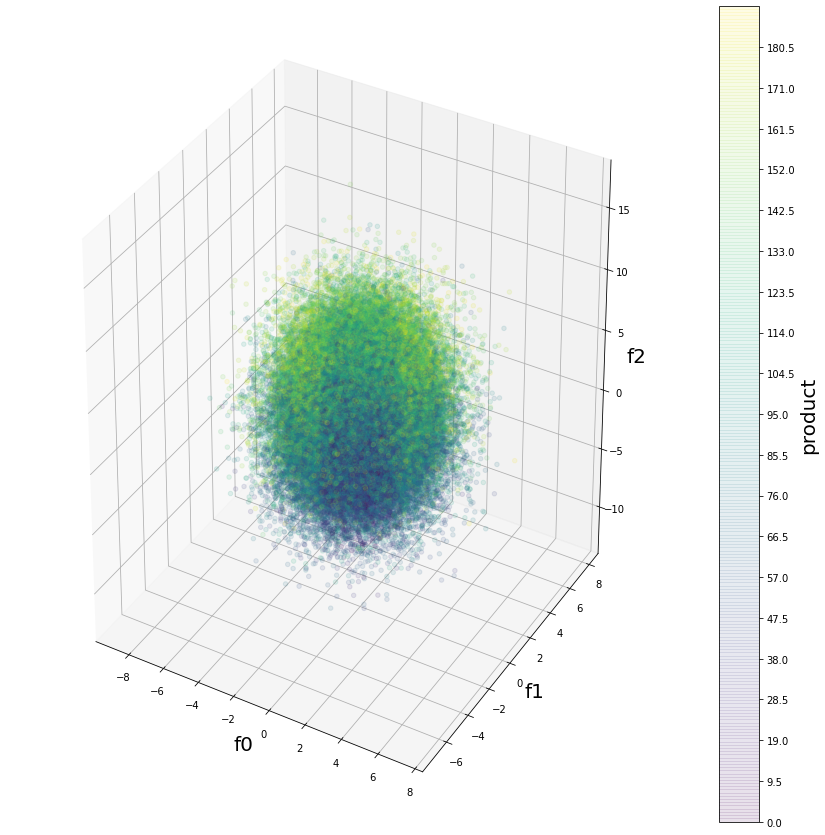

In [18]:
show_f0123_scatter(geo_data_2) #Регион 2

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных переменных:

- `well_count` - количество исследуемых точек при разведке
- `best_count` - количество лучших точек для разработки
- `revenue_per_unit` - доход с каждой единицы продукта
- `budget` - бюджет на разработку скважин в регионе
- `bootstrap_count` - количество выборок для bootstrap
- `well_cost` - вычисляем как `budget` / `well_count` - цена разработки одной скважины
- `min_product` - вычисляем как `well_cost` / `revenue_per_unit` - минимальное количества продукта в скважине для ее безубыточной разработки

In [19]:
well_count = 500
best_count = 200
revenue_per_unit = 450000
budget = 10000000000
bootstrap_count = 1000
well_cost = budget / best_count
profitable_product = well_cost / revenue_per_unit

In [20]:
print('Достаточный объём сырья для безубыточной разработки новой скважины: ', end='')
print('%.2f'%profitable_product, 'единиц')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 единиц


### Вывод

Мы подготовились к расчету прибыли. Обратим внимание, что для безубыточной разработки скважины необходимо, чтобы в ней содержалось как минимум 111.11 единиц продукта. Средние значения продукта в скважинах по регионам существенно ниже этой величины. Таким образом, к выбору новых скважин для разработки следует подходить с большой ответственностью, в этом нам поможет наша модель.

## Расчёт прибыли и рисков 

Определим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- Выберем скважины с максимальными значениями предсказаний.
- Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитаем прибыль для полученного объёма сырья.

In [21]:
def revenue(data, count):
    predict_sorted = data['predict'].sort_values(ascending=False)
    selected = data['target'][predict_sorted.index][:count]
    return revenue_per_unit * selected.sum()

Определим функцию для расчета рисков и прибыли техникой Bootstrap:

In [22]:
def bootstrap_calc(data, count):   
    values = []
    for i in range(count):
        subsample = pd.DataFrame()
        subsample['target'] = data['target'].sample(well_count, replace=True, random_state=state)
        subsample['predict'] = data['predict'][subsample['target'].index]
        rev = revenue(subsample, best_count)
        values.append(rev)
    values = pd.Series(values)
    return values

Определим функцию для вывода на экран наших расчетов:

In [23]:
def print_mean_and_quantiles(values, quantile_lower=.025, quantile_higher=.975):
    lower = values.quantile(quantile_lower) / 1000000000
    mean = values.mean() / 1000000000
    higher = values.quantile(quantile_higher) / 1000000000
    risk = stats.percentileofscore(values, budget)
    print('Средняя выручка:', '%.2f'%mean, 'млрд руб')
    print(str(quantile_lower*100)+'%-квантиль:', '%.2f'%lower, 'млрд руб')
    print(str(quantile_higher*100)+'%-квантиль:', '%.2f'%higher, 'млрд руб')
    print('Риск убытков:', '%.0f'%risk,'%')

### Регион 0:

In [24]:
geo_0_bootstrap = bootstrap_calc(result_0, bootstrap_count)
print('Расчет среднего и квантилей для региона 0:')
print()
print_mean_and_quantiles(geo_0_bootstrap)

Расчет среднего и квантилей для региона 0:

Средняя выручка: 10.43 млрд руб
2.5%-квантиль: 9.90 млрд руб
97.5%-квантиль: 10.95 млрд руб
Риск убытков: 6 %


### Регион 1:

In [25]:
geo_1_bootstrap = bootstrap_calc(result_1, bootstrap_count)
print('Расчет среднего и квантилей для региона 1:')
print()
print_mean_and_quantiles(geo_1_bootstrap)

Расчет среднего и квантилей для региона 1:

Средняя выручка: 10.52 млрд руб
2.5%-квантиль: 10.13 млрд руб
97.5%-квантиль: 10.95 млрд руб
Риск убытков: 0 %


### Регион 2:

In [26]:
geo_2_bootstrap = bootstrap_calc(result_2, bootstrap_count)
print('Расчет среднего и квантилей для региона 2:')
print()
print_mean_and_quantiles(geo_2_bootstrap)

Расчет среднего и квантилей для региона 2:

Средняя выручка: 10.42 млрд руб
2.5%-квантиль: 9.88 млрд руб
97.5%-квантиль: 10.99 млрд руб
Риск убытков: 6 %


### Вывод:

Мы расчитали средние выручки для трех регионов и риски убытков. Вероятности убытков для регионов 0 и 2 превосходят 2,5%, а в регионе 1 риски ниже 2.5%. Ожидаемая выручка в регионах 0 и 2 практически одинакова. Ожидаемая выручка в регионе 1 выше, чем в регионах 0 и 2. Таким образом регион 1 является однозначно лучшим для разработки и с точки зрения ожидаемой выручки, и с точки зрения рисков.

## Общий вывод:

Полученный результат весьма ожидаем. Хоть в регионе 1 средние запасы продуктов в шахтах существенно ниже, чем в регионах 0 и 2, в регионе 1 мы можем предсказать значения целевого признака с очень высокой точностью, поскольку мы пользуемся моделью линейной регрессии, а наш целевой признак линейно зависит от признака `f2` в регионе 1. Это утверждение не справедливо для регионов 0 и 2, поэтому в них мы делаем предсказания недостаточно точно, что значительно влияет на ожидаемую прибыль и существенно увеличивает риски. 